#Preparation

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=aaf134ac477c039c3cb8b5fdc4726a0814c2c630694f40718a32d3ce2a0df198
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/Big Data/proj/"  # this is your drive
#data_path = "/content/drive/MyDrive/Colab Notebooks/proj/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# create entry points to spark
from pyspark.sql import SparkSession

ss  = SparkSession.builder \
                            .master("local[1]")\
                            .appName("SparkByExamples.com")\
                            .getOrCreate()
spark = ss.sparkContext

#Read file

In [ ]:
df = ss.read.csv(data_path + 'Lab_Loan_Default_prediction_dataset.csv', header=True, inferSchema=True)
df.show(5)

+--------+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+--------------------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+-----------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
|      ID|Loan_Amount|Funded_Amount|Funded_Amount_Investor|Term|Batch_Enrolled|Interest_Rate|Grade|Sub_Grade|Employment_Duration|Home_Ownership|Verification_Status|Payment_Plan|          Loan_Title|Debit_to_Income|Delinquency_-_two_years|Inquires_-_six_months|Open_Account|Public_Record|Revolving_Balance|Revolving_Utilities|Total_Accounts|Initial_List_Status|Total_Received_Interest|Tota

In [ ]:
df.withColumnRenamed('Employment_Duration', 'temp')\
  .withColumnRenamed('Home_Ownership', 'Employment_Duration')\
  .withColumnRenamed('temp', 'Home_Ownership')\
  .drop('temp').show(5)

+--------+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+--------------+-------------------+-------------------+------------+--------------------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+-----------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
|      ID|Loan_Amount|Funded_Amount|Funded_Amount_Investor|Term|Batch_Enrolled|Interest_Rate|Grade|Sub_Grade|Home_Ownership|Employment_Duration|Verification_Status|Payment_Plan|          Loan_Title|Debit_to_Income|Delinquency_-_two_years|Inquires_-_six_months|Open_Account|Public_Record|Revolving_Balance|Revolving_Utilities|Total_Accounts|Initial_List_Status|Total_Received_Interest|Tota

# Data visualization

In [ ]:
df.describe().show()

+-------+-------------------+-----------------+-----------------+----------------------+------------------+--------------+------------------+-----+---------+-------------------+-----------------+-------------------+------------+-----------+------------------+-----------------------+---------------------+-----------------+-------------------+-----------------+-------------------+-----------------+-------------------+-----------------------+-----------------------+------------------+-----------------------+----------------------------+----------------+-----------------+-------------------+-----------------------+---------------------+----------------------------+------------------+
|summary|                 ID|      Loan_Amount|    Funded_Amount|Funded_Amount_Investor|              Term|Batch_Enrolled|     Interest_Rate|Grade|Sub_Grade|Employment_Duration|   Home_Ownership|Verification_Status|Payment_Plan| Loan_Title|   Debit_to_Income|Delinquency_-_two_years|Inquires_-_six_months|     O

# Feature transformation

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# quick function to transform data into feature, label
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

transformed = get_dummy(df, ['Grade', 'Sub_Grade', 'Employment_Duration', 'Verification_Status', 'Loan_Title', 'Initial_List_Status', 'Application_Type'],
                        ['Loan_Amount', 'Funded_Amount', 'Funded_Amount_Investor', 'Term', 'Interest_Rate', 'Home_Ownership', 'Debit_to_Income', 'Delinquency_-_two_years', 'Inquires_-_six_months', 'Open_Account', 'Public_Record', 'Revolving_Balance', 'Revolving_Utilities', 'Total_Accounts',
                         'Total_Received_Interest', 'Total_Received_Late_Fee', 'Recoveries', 'Collection_Recovery_Fee', 'Collection_12_months_Medical', 'Last_week_Pay', 'Accounts_Delinquent', 'Total_Collection_Amount', 'Total_Current_Balance', 'Total_Revolving_Credit_Limit'],
                        'Loan_Status')

In [ ]:
transformed.schema["features"].metadata["ml_attr"]["num_attrs"]

157

# Baseline model

Logistic regression

In [ ]:
##=====build cross valiation model======
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# define evaluator
#evaluator = RegressionEvaluator(labelCol="label",
#                  predictionCol="prediction",
#                  metricName="mse")
evaluator = RegressionEvaluator(labelCol="label",
                  predictionCol="prediction")

loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

loan_lr = LinearRegression(featuresCol='features', labelCol='label')

loan_param_grid = ParamGridBuilder().\
    addGrid(loan_lr.regParam, [0.1, 0.01, 1]).\
    addGrid(loan_lr.fitIntercept, [False, True]).\
    build()

cv = CrossValidator(estimator=loan_lr, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(loan_training)

loan_pred_training_cv = cv_model.transform(loan_training)
loan_pred_test_cv = cv_model.transform(loan_test)

mse = evaluator.evaluate(loan_pred_test_cv)
print("Mean Squared Error (MSE) on test data = %g" % mse)

Mean Squared Error (MSE) on test data = 0.50021


In [ ]:
##=====build cross valiation model======
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label",
                  rawPredictionCol = 'rawPrediction',
                  metricName="areaUnderROC")

loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

loan_lr = LogisticRegression(featuresCol='features', labelCol='label', family='binomial')

loan_param_grid = ParamGridBuilder().\
    addGrid(loan_lr.maxIter, [25, 50, 75, 100]).\
    addGrid(loan_lr.regParam, [0.1, 0.01, 1]).\
    addGrid(loan_lr.fitIntercept, [False, True]).\
    build()

cv = CrossValidator(estimator=loan_lr, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(loan_training)

loan_pred_training_cv = cv_model.transform(loan_training)
loan_pred_test_cv = cv_model.transform(loan_test)

print("Test_SET Area Under ROC: " + str(evaluator.evaluate(loan_pred_test_cv, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.5053252941663724


#Comparing models

## Single models

model 1: Random Forest

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(numTrees=200, subsamplingRate=0.63, seed=42, featuresCol='features', labelCol='label', rawPredictionCol='rawPrediction_rf')

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")

loan_param_grid = ParamGridBuilder().build()

cv = CrossValidator(estimator=rf, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(loan_training)

loan_pred_training_cv = cv_model.transform(loan_training)
loan_pred_test_cv = cv_model.transform(loan_test)

print("Test_SET Area Under ROC: " + str(evaluator.evaluate(loan_pred_test_cv, {evaluator.metricName: "areaUnderROC"})))
print()

Test_SET Area Under ROC: 0.5277926731973999



model 2: naive bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator

loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

cv = CrossValidator(estimator=rf, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(loan_training)

cv_predictions = cv_model.transform(loan_test)

cv_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction",
                                              metricName="areaUnderROC")

areaUnderROC_nb = cv_evaluator.evaluate(cv_predictions)
print("Test set ROC = " + str(areaUnderROC_nb))

Test set ROC = 0.5277926731973999


## Ensembled models

model 2: random forest + logistic regression

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline


rf = RandomForestClassifier(numTrees=200, seed=42, featuresCol='features', labelCol='label',
                            predictionCol='prediction_rf', rawPredictionCol='rawPrediction_rf', probabilityCol='probability_rf')

rf2 = LogisticRegression(featuresCol='probability_rf', labelCol='label',
                            predictionCol='prediction_rf2', rawPredictionCol='rawPrediction_rf2', probabilityCol='probability_rf2')

evaluator = BinaryClassificationEvaluator(labelCol="label",
                  rawPredictionCol = 'rawPrediction_rf2',
                  metricName="areaUnderROC")

pipeline = Pipeline(stages = [rf, rf2])
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(loan_training)

# prediction
loan_pred_training_cv = cv_model.transform(loan_training)
loan_pred_test_cv = cv_model.transform(loan_test)

ensemble_acc = evaluator.evaluate(loan_pred_test_cv)

print("Result:")
print('-'*80)
print('A ensemble model had an accuracy of: {0:2.2f}%'.format(ensemble_acc*100))

Result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 54.72%


different combination of iter with subsampling

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline


loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

evaluator = BinaryClassificationEvaluator(labelCol="label",
                  rawPredictionCol = 'rawPrediction_lg',
                  metricName="areaUnderROC")

for i in range(50,275, 25):

    rf = RandomForestClassifier(numTrees=i, subsamplingRate=0.63, seed=42 ,featuresCol='features', labelCol='label',
                                  predictionCol='prediction_rf'+str(i), rawPredictionCol='rawPrediction_rf'+str(i), probabilityCol='probability_rf'+str(i))

    lg = LogisticRegression(maxIter=25, regParam=0.3, elasticNetParam=0.2, featuresCol='probability_rf'+str(i), labelCol='label',
                                  predictionCol='prediction_lg', rawPredictionCol='rawPrediction_lg', probabilityCol='probability_lg')

    loan_param_grid = ParamGridBuilder().\
      addGrid(lg.regParam, [0.1, 0.01, 1]).\
      addGrid(lg.fitIntercept, [False, True]).\
      build()

    pipeline = Pipeline(stages = [rf, lg])

    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)

    cv_model = cv.fit(loan_training)

    loan_pred_training_cv = cv_model.transform(loan_training)
    loan_pred_test_cv = cv_model.transform(loan_test)

    ensemble_acc = evaluator.evaluate(loan_pred_test_cv)

    print("Loop ", i , " result:")
    print('-'*80)
    print('A ensemble model had an accuracy of: {0:2.2f}%'.format(ensemble_acc*100))
    print()

Loop  50  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 54.09%

Loop  75  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 52.01%

Loop  100  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 54.13%

Loop  125  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 53.47%

Loop  150  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 54.21%

Loop  175  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 52.56%

Loop  200  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy

without subsampling

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

evaluator = BinaryClassificationEvaluator(labelCol="label",
                  rawPredictionCol = 'rawPrediction_lg',
                  metricName="areaUnderROC")

for i in range(50,275, 25):

    rf = RandomForestClassifier(numTrees=i, seed=42, featuresCol='features', labelCol='label',
                                  predictionCol='prediction_rf'+str(i), rawPredictionCol='rawPrediction_rf'+str(i), probabilityCol='probability_rf'+str(i))

    lg = LogisticRegression(maxIter=25, regParam=0.3, elasticNetParam=0.2, featuresCol='probability_rf'+str(i), labelCol='label',
                                  predictionCol='prediction_lg', rawPredictionCol='rawPrediction_lg', probabilityCol='probability_lg')

    loan_param_grid = ParamGridBuilder().\
      addGrid(lg.regParam, [0.1, 0.01, 1]).\
      addGrid(lg.fitIntercept, [False, True]).\
      build()

    pipeline = Pipeline(stages = [rf, lg])
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)
    cv_model = cv.fit(loan_training)

    loan_pred_training_cv = cv_model.transform(loan_training)
    loan_pred_test_cv = cv_model.transform(loan_test)

    ensemble_acc = evaluator.evaluate(loan_pred_test_cv)

    print("Loop ", i , " result:")
    print('-'*80)
    print('A ensemble model had an accuracy of: {0:2.2f}%'.format(ensemble_acc*100))
    print()

Loop  50  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 51.81%

Loop  75  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 52.66%

Loop  100  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 52.95%

Loop  125  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 52.75%

Loop  150  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 53.19%

Loop  175  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 54.34%

Loop  200  result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy

model 3: Naive Bayes + Random Forest


In [ ]:
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder

loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

loan_param_grid = ParamGridBuilder().build()


rf = RandomForestClassifier(numTrees=200, seed=42, featuresCol='features', labelCol='label',
                              predictionCol='prediction_rf', rawPredictionCol='rawPrediction_rf', probabilityCol='probability_rf')

rf2 = NaiveBayes(featuresCol='probability_rf', labelCol='label',
                              predictionCol='prediction_rf2', rawPredictionCol='rawPrediction_rf2', probabilityCol='probability_rf2', smoothing=1.0, modelType="multinomial")

evaluator = BinaryClassificationEvaluator(labelCol="label",
                    rawPredictionCol = 'rawPrediction_rf2',
                    metricName="areaUnderROC")

pipeline = Pipeline(stages = [rf, rf2])
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)
cv_model = cv.fit(loan_training)

loan_pred_training_cv = cv_model.transform(loan_training)
loan_pred_test_cv = cv_model.transform(loan_test)

ensemble_acc = evaluator.evaluate(loan_pred_test_cv)

print("Loop "," result:")
print('-'*80)
print('A ensemble model had an accuracy of: {0:2.2f}%'.format(ensemble_acc*100))
print()

Loop   result:
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 54.72%



model 4: Naive Bayes + Decision Tree + Logistic Regression + Random Forest

In [ ]:
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

loan_training, loan_test = transformed.randomSplit([0.8, 0.2], seed=42)

rf = NaiveBayes(featuresCol='features', labelCol='label',
                            predictionCol='prediction_rf', rawPredictionCol='rawPrediction_rf', probabilityCol='probability_rf', smoothing=1.0, modelType="multinomial")

rf2 = DecisionTreeClassifier(featuresCol='probability_rf', labelCol='label',
                            predictionCol='prediction_rf2', rawPredictionCol='rawPrediction_rf2', probabilityCol='probability_rf2')

lg = LogisticRegression(maxIter=50, regParam=0.3, elasticNetParam=0.2, featuresCol='probability_rf2', labelCol='label',
                                  predictionCol='prediction_lg', rawPredictionCol='rawPrediction_lg', probabilityCol='probability_lg')

rf3 = RandomForestClassifier(numTrees=200, seed=42, featuresCol='probability_lg', labelCol='label',
                              predictionCol='prediction_rf3', rawPredictionCol='rawPrediction_rf3', probabilityCol='probability_rf3')

evaluator = BinaryClassificationEvaluator(labelCol="label",
                  rawPredictionCol = 'rawPrediction_rf3',
                  metricName="areaUnderROC")

loan_param_grid = ParamGridBuilder().build()

pipeline = Pipeline(stages = [rf, rf2, lg, rf3])
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=loan_param_grid, evaluator=evaluator, numFolds=5)

cv_model = cv.fit(loan_training)

loan_pred_training_cv = cv_model.transform(loan_training)
loan_pred_test_cv = cv_model.transform(loan_test)

ensemble_acc = evaluator.evaluate(loan_pred_test_cv)

print("Here are the results!")
print('-'*80)
print('A ensemble model had an accuracy of: {0:2.2f}%'.format(ensemble_acc*100))


Here are the results!
--------------------------------------------------------------------------------
A ensemble model had an accuracy of: 50.00%


# Visualization

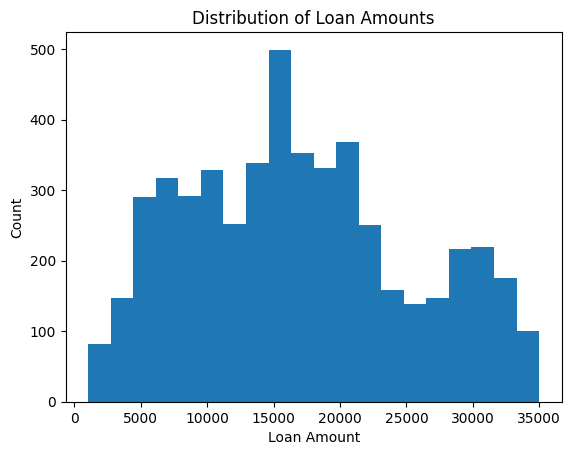

In [ ]:
import matplotlib.pyplot as plt

loan_amount = df.select(col("Loan_Amount"))

loan_amount_pd = loan_amount.toPandas()

# Plot a histogram of the Loan_Amount column
fig, ax = plt.subplots()
ax.hist(loan_amount_pd["Loan_Amount"], bins=20)
ax.set_xlabel("Loan Amount")
ax.set_ylabel("Count")
ax.set_title("Distribution of Loan Amounts")
plt.show()

In [ ]:
loan_amount_pd["Loan_Amount"].skew()

0.2743322088940716

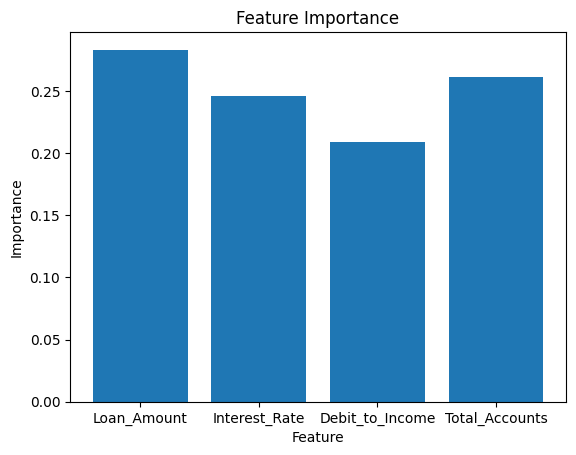

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

feature_cols = ['Loan_Amount', 'Interest_Rate', 'Debit_to_Income', 'Total_Accounts']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

label_indexer = StringIndexer(inputCol="Loan_Status", outputCol="label")

rf = RandomForestRegressor(featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[assembler, label_indexer, rf])

model = pipeline.fit(train_data)

importances = model.stages[-1].featureImportances.toArray()

# Create a bar chart of the feature importances
fig, ax = plt.subplots()
ax.bar(feature_cols, importances)
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
ax.set_title("Feature Importance")
plt.show()


In [ ]:
importances

array([0.28351648, 0.24580833, 0.20884943, 0.26182577])

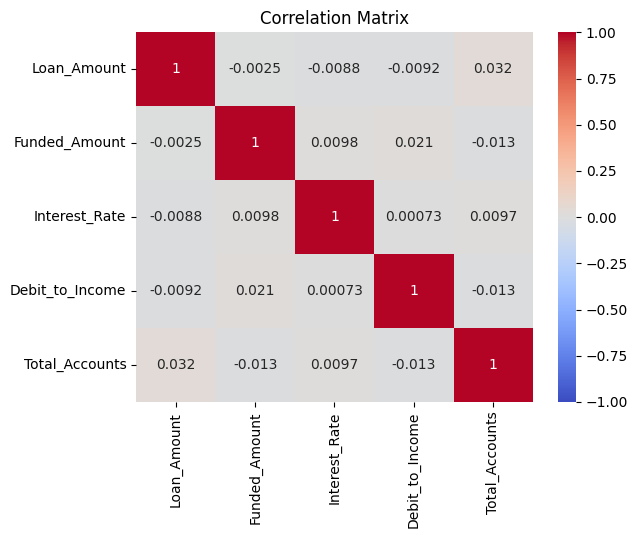

In [ ]:
import seaborn as sns
from pyspark.ml.stat import Correlation
import pandas as pd

feature_cols = ['Loan_Amount', 'Funded_Amount', 'Interest_Rate', 'Debit_to_Income', 'Total_Accounts']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
transformed_data = assembler.transform(df).select("features")

# Calculate the correlation matrix
corr_matrix = Correlation.corr(transformed_data, "features").head()[0]
corr_df = pd.DataFrame(corr_matrix.toArray(), columns=feature_cols, index=feature_cols)

# Create a heatmap of the correlation matrix using Seaborn
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
corr_df

,Loan_Amount,Funded_Amount,Interest_Rate,Debit_to_Income,Total_Accounts
Loan_Amount,1.000000,-0.002472,-0.008778,-0.009197,0.032385
Funded_Amount,-0.002472,1.000000,0.009849,0.020910,-0.013053
Interest_Rate,-0.008778,0.009849,1.000000,0.000732,0.009655
Debit_to_Income,-0.009197,0.020910,0.000732,1.000000,-0.012514
Total_Accounts,0.032385,-0.013053,0.009655,-0.012514,1.000000


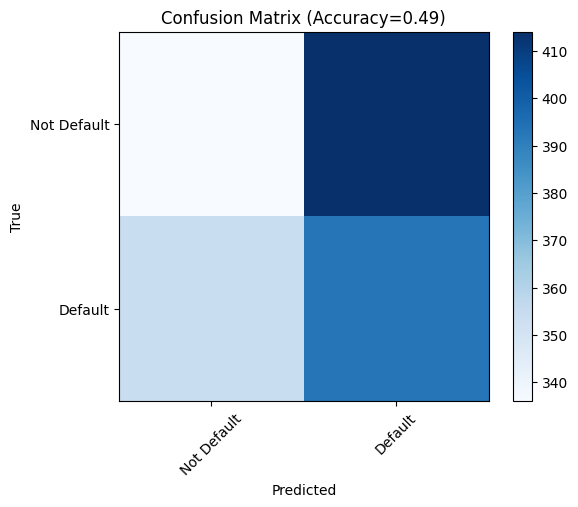

In [ ]:
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import VectorAssembler

inputCols = ['Loan_Amount', 'Funded_Amount', 'Funded_Amount_Investor', 'Term']
assembler = VectorAssembler(inputCols=inputCols, outputCol='features')

df = assembler.transform(df)
(training_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="Loan_Status", featuresCol="features", numTrees=10, maxDepth=5)
model = rf.fit(training_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
confusion_matrix = predictions.groupBy("Loan_Status", "prediction").count().orderBy("Loan_Status", "prediction")
confusion_matrix_np = np.array(confusion_matrix.select("count").collect()).reshape(2, 2)

plt.imshow(confusion_matrix_np, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Not Default", "Default"], rotation=45)
plt.yticks(tick_marks, ["Not Default", "Default"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Accuracy={:.2f})'.format(accuracy))
plt.show()


In [ ]:
confusion_matrix_np

array([[336, 414],
       [354, 393]])